
Identify at least two sets of parallel lines in this house front (e.g., the top edge of the window and the door, the bottom edge of the window, and the bottom edge of the house form a set of three parallel lines). You can use the Hough transform to identify lines, or any other means to get the coordinates of specific points on those lines. If you do not manage to do this, you can read off the coordinates of those points manually (but this will give less points).
Compute the intersection points of these sets of parallel lines (ideally, all parallel lines from one set intersect in a common point, but due to inaccuracies in the determination of the line coordinates, they may intersect in different points; in that case, find the intersection point by using a simple least squares method, i.e., find the point that is closest to all different intersection points).
Map back the line that connects the intersection points (if you take more than two sets of parallel lines, you may again have to find the best-fitting line to the intersection points) to the line at infinity and apply this transformation to the given image, resulting in an image B.

In [11]:

#@title Imports
import cv2
#from google.colab.patches import cv2_imshow
#from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import math


In [12]:
#@title Load Images

#drive.mount("/content/drive/")
imgpath = './house1.png'
shtepi = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
print(np.shape(shtepi))
cv2.imshow('house',shtepi)

(540, 960)


In [13]:
#@title Image segmentation based on histogram

# This function performs image segmentation based on histogram values
def image_segmentation_hist_based(obj, hist_val_min=0, hist_val_max=255):

  # 'obj' is assumed to be a 2D array representing the image
  # 'hist_val_min' and 'hist_val_max' are the lower and upper boundaries for histogram values, respectively

  # Get the height and width of the image
  M = obj.shape[0]
  N = obj.shape[1]

  # Iterate over every pixel in the image
  for i in range(0,M):
    for j in range(0,N):

      # If the pixel intensity is less than the minimum threshold,
      # set the pixel intensity to 0 (Black)
      if obj[i,j] < hist_val_min:
        obj[i,j] = 0

      # If the pixel intensity is greater than the maximum threshold,
      # also set the pixel intensity to 0 (Black)
      elif obj[i,j] > hist_val_max:
        obj[i,j] = 0

      # If the pixel intensity is within the threshold range,
      # set the pixel intensity to 250 (almost White, but not completely)
      else:
        obj[i,j] = 250

  # Return the segmented image
  return obj


In [14]:
#@title Utility Function: Kernel filter
#Kernel filter

# This function applies a convolutional kernel filter on an image
def kernel_filter(obj, matrx=[[0,0,0],[0,1,0],[0,0,0]]):

  # 'obj' is assumed to be a 2D array representing the image
  # 'matrx' is the convolutional kernel; by default, it is an identity matrix that will leave the image unchanged

  # Get the height and width of the image
  M = obj.shape[0]
  N = obj.shape[1]

  # Parameters a and b are used to define the range of the convolutional kernel
  # They are also used to exclude the border of the image where the kernel cannot be applied
  a = 1
  b = a

  # m and n are the height and width of the kernel
  m = 2*a+1
  n = 2*b+1

  # 'w' is the convolutional kernel, converted to a numpy array for efficient processing
  w = np.array(matrx)

  # 'B' is a copy of the original image, where the results of the convolution will be stored
  B = np.copy(obj)

  # Iterate over every pixel in the image, excluding the border
  for i in range(a,M-a):
    for j in range(b,N-b):

      # 'I' is the result of applying the convolutional kernel to the current pixel and its neighbors
      I = 0
      for s in range(-a,a+1):
        for t in range(-b,b+1):
          # Multiply the corresponding kernel value by the intensity of the neighbor pixel, and add it to 'I'
          I = I + w[s+a,t+b] * obj[i+s,j+t]

      # Set the intensity of the current pixel in the output image to the result of the convolution,
      # rounded to the nearest integer
      B[i,j] = round(I)

  # Return the filtered image
  return B



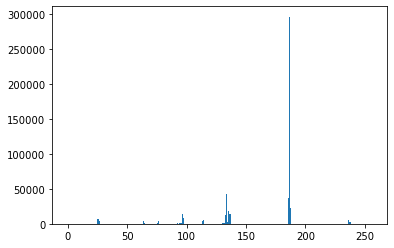

In [15]:
#@title Image segmentation plot
L= 256

H, bins, ignored = plt.hist(shtepi.ravel(),L,[0,L])
plt.show()

In [16]:
#@title Separation based by histogram.
window_door = shtepi.copy()
window_door = image_segmentation_hist_based(window_door, hist_val_min=0,hist_val_max=70 )

cv2.imshow('casa',window_door)

In [17]:
#@title Separation based by histogram.
window = shtepi.copy()
window = image_segmentation_hist_based(window, hist_val_min=60,hist_val_max=65 )

cv2.imshow('c', window)

In [18]:
#@title Separation based by histogram.
door = shtepi.copy()
door = image_segmentation_hist_based(door, hist_val_min=0,hist_val_max=50 )

cv2.imshow('house',door)

In [19]:
#@title Utility Function: Kernel filter
#Kernel filter
def kernel_filter(obj, matrx=[[0,0,0],[0,1,0],[0,0,0]]):

  #get H & W
  M = obj.shape[0]
  N = obj.shape[1]

  a = 1
  b = a
  m = 2*a+1
  n = 2*b+1

  w = np.array(matrx)

  B = np.copy(obj)
  for i in range(a,M-a):
    for j in range(b,N-b):
      I = 0
      for s in range(-a,a+1):
        for t in range(-b,b+1):
          I = I + w[s+a,t+b] * obj[i+s,j+t]
      B[i,j] = round(I)

  # cv2_imshow(B)
  return B

In [21]:
#@title aux function Canny
# The solution was for canny edge detector was inspired by Canny: https://github.com/FienSoP/canny_edge_detector/blob/master/canny_edge_detector.py

from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc

from scipy import ndimage
import numpy as np
import imageio

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)


    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(img)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final


detector = cannyEdgeDetector([window_door])
detected_images = detector.detect()
edge_detected_image = detected_images[0]
# cv2.imshow('edges',edge_detected_image)



<ipython-input-21-1001711fc3e3>:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve
<ipython-input-21-1001711fc3e3>:41: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
<ipython-input-21-1001711fc3e3>:42: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


In [22]:
#@title utility Function lines = (vert,hor)
def lines(image,show=False, threshold=95,threshold_h=95):
  d=image.copy()
  vertical_lines = kernel_filter(d, matrx=[[-1,2,-1],[-1,2,-1],[-1,2,-1]])
  horizontal_lines = kernel_filter(d, matrx=[[-1,-1,-1],[2,2,2],[-1,-1,-1]])
  import numpy as np

  def hough_transform(image):
      width, height = image.shape
      diag_len = int(np.round(np.sqrt(width**2 + height ** 2)))
      thetas = np.deg2rad(np.arange(-90, 90))
      rhos = np.linspace(-diag_len, diag_len, 2*diag_len)
      accumulator = np.zeros((2 * diag_len, len(thetas)))

      cos_t = np.cos(thetas)
      sin_t = np.sin(thetas)
      num_thetas = len(thetas)

      y_idxs, x_idxs = np.nonzero(image)
      for i in range(len(x_idxs)):
          x = x_idxs[i]
          y = y_idxs[i]

          for t_idx in range(num_thetas):
              rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
              accumulator[rho, t_idx] += 1

      return accumulator, thetas, rhos


  def draw_lines(image, accumulator, thetas, rhos, threshold):
      lines_info = np.where(accumulator > threshold)

      for i in range(len(lines_info[0])):
          rho = rhos[lines_info[0][i]]
          theta = thetas[lines_info[1][i]]

          a = np.cos(theta)
          b = np.sin(theta)
          x0 = a * rho
          y0 = b * rho

          # Points on the line
          x1 = int(x0 + 1000 * (-b))
          y1 = int(y0 + 1000 * (a))
          x2 = int(x0 - 1000 * (-b))
          y2 = int(y0 - 1000 * (a))

          # Draw the line
          cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

      return image

  # Compute the Hough transform
  accumulator, thetas, rhos = hough_transform(vertical_lines)
  lines_info_vert = np.where(accumulator > threshold)
  lines_vert = [(rhos[i], thetas[j]) for i, j in zip(*lines_info_vert)]
  if show:
    img = shtepi.copy()
    lines_img = 0
    # Draw lines on the original image
    lines_img = draw_lines(img, accumulator, thetas, rhos, threshold=threshold)
    # Compute the Hough transform
  accumulator, thetas, rhos = hough_transform(horizontal_lines)
  lines_info_hor = np.where(accumulator > threshold_h)
  lines_hor = [(rhos[i], thetas[j]) for i, j in zip(*lines_info_hor)]


  if show:
    # img = shtepi.copy()
    # Draw lines on the original image
    lines_img = draw_lines(img, accumulator, thetas, rhos, threshold=threshold_h)

    # Display the image using matplotlib
    plt.imshow(lines_img, cmap='gray')
    plt.show()
  return lines_vert,lines_hor



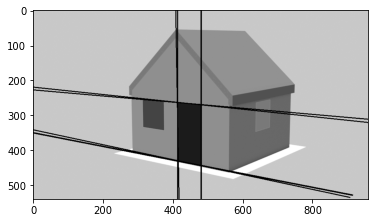

In [23]:
d_vert,d_hor = lines(door, show=True, threshold=120,threshold_h=67)

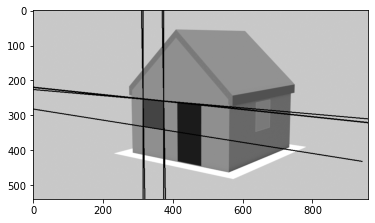

In [24]:
w_vert,w_hor = lines(window , show=True, threshold=80,threshold_h=61)


In [ ]:
# Function to calculate the intersection point of two lines
def line_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])

    try:
        x0, y0 = np.linalg.solve(A, b)
        x0, y0 = int(np.round(x0)), int(np.round(y0))
        return [[x0, y0]]
    except np.linalg.LinAlgError:
        # The lines are parallel and don't intersect
        return None

In [ ]:
def polar_to_cartesian(rho, theta):
    a = np.sin(theta)
    b = np.cos(theta)
    c = -rho
    return np.array([a, b, c])

    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho

    # Points on the line
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))


    return np.cross((x1,y1,1),(x2,y2,1)) #np.array([a, b, c])

In [ ]:
def intersect_lines(arr_lines, less=0, more=0, ax=0):

  n = len(arr_lines)

  intersections = []

  for i in range(n):
      for j in range(i+1, n):
          rho1, theta1 = arr_lines[i]
          rho2, theta2 = arr_lines[j]

          line1 = polar_to_cartesian(rho1, theta1)
          line2 = polar_to_cartesian(rho2, theta2)

          intersection_point = np.cross(line1, line2)

          if intersection_point[2] != 0:
              intersection_point = intersection_point / intersection_point[-1]
              #Remove the intersections at positive.
              if intersection_point[ax] < less and intersection_point[ax] > more or True:
                intersections.append(intersection_point)
  return intersections


In [ ]:
def scatter_intersections(points):
  x =[]
  y = []
  for i in range(len(points)) :
    # print(intersections_hor[i][0])
    x.append(points[i][0])
    # print(intersections_hor[i][2])
    y.append(points[i][1])

  plt.scatter(x,y)
  # ax = plt.gca()
  # ax.set_ylim(ax.get_ylim()[::-1])
  plt.show()

In [ ]:
vert = w_vert + d_vert
hor = w_hor + d_hor
# p_vert = intersect_lines(vert,less=100000, more=-100000,ax=1)
# p_hor = intersect_lines(hor,less=100000, more=0,ax=0)
p_vert = intersect_lines(vert,less=00, more=-10000,ax=1)
p_hor = intersect_lines(hor,less=0, more=-1800,ax=0)

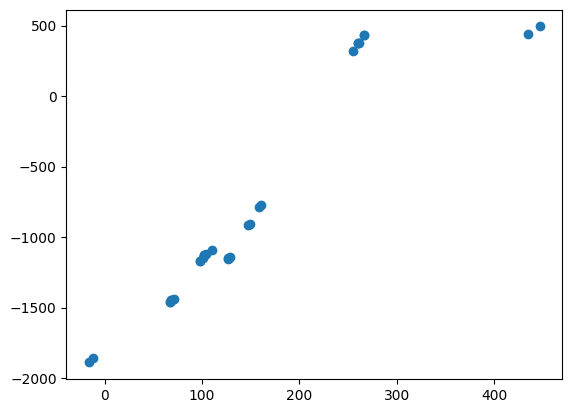

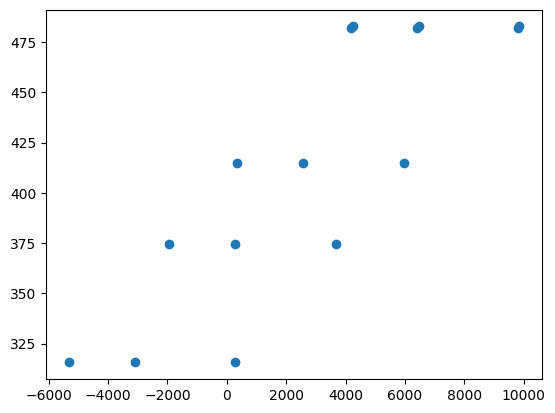

In [ ]:
scatter_intersections(p_hor)
scatter_intersections(p_vert)

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters).fit(p_hor)

labels = kmeans_model.labels_

cluster_points = {i: [] for i in range(n_clusters)}
for i, label in enumerate(labels):
    cluster_points[label].append(p_hor[i])

cluster_centers= []
for i in range(n_clusters):
    points = np.array(cluster_points[i])
    centroid = np.linalg.lstsq(np.ones((points.shape[0], 1)), points, rcond=None)[0]
    cluster_centers.append(centroid[0])
    print(f"Centroid of cluster {i+1} is at coordinates: {centroid[0]}")

Centroid of cluster 1 is at coordinates: [306.69706026 407.11285108   1.        ]
Centroid of cluster 2 is at coordinates: [ 6.87402423e+01 -1.45003123e+03  1.00000000e+00]
Centroid of cluster 3 is at coordinates: [ 1.22811574e+02 -1.06175432e+03  1.00000000e+00]
Centroid of cluster 4 is at coordinates: [-1.38271597e+01 -1.87480369e+03  1.00000000e+00]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.cluster import KMeans
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters).fit(p_vert)

labels = kmeans_model.labels_

cluster_points = {i: [] for i in range(n_clusters)}
for i, label in enumerate(labels):
    cluster_points[label].append(p_vert[i])

cluster_centers_v = []
for i in range(n_clusters):
    points = np.array(cluster_points[i])
    centroid = np.linalg.lstsq(np.ones((points.shape[0], 1)), points, rcond=None)[0]
    cluster_centers_v.append(centroid[0])
    print(f"Centroid of cluster {i+1} is at coordinates: {centroid[0]}")

Centroid of cluster 1 is at coordinates: [870.8864695  379.92253521   1.        ]
Centroid of cluster 2 is at coordinates: [5.15527133e+03 4.53039073e+02 1.00000000e+00]
Centroid of cluster 3 is at coordinates: [-3.46151782e+03  3.35318946e+02  1.00000000e+00]
Centroid of cluster 4 is at coordinates: [9.82698148e+03 4.82218991e+02 1.00000000e+00]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import itertools

points = cluster_centers
combinations = list(itertools.combinations(points, 2))

print(combinations)

[(array([306.69706026, 407.11285108,   1.        ]), array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00])), (array([306.69706026, 407.11285108,   1.        ]), array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00])), (array([306.69706026, 407.11285108,   1.        ]), array([-1.38271597e+01, -1.87480369e+03,  1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([-1.38271597e+01, -1.87480369e+03,  1.00000000e+00])), (array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00]), array([-1.38271597e+01, -1.87480369e+03,  1.00000000e+00]))]


In [ ]:

# # initialize lists
list_1 = cluster_centers
list_2 = cluster_centers_v

unique_combinations = []

for i in range(len(list_1)):
    for j in range(len(list_2)):
        unique_combinations.append((list_1[i], list_2[j]))

print(unique_combinations)

[(array([306.69706026, 407.11285108,   1.        ]), array([870.8864695 , 379.92253521,   1.        ])), (array([306.69706026, 407.11285108,   1.        ]), array([5.15527133e+03, 4.53039073e+02, 1.00000000e+00])), (array([306.69706026, 407.11285108,   1.        ]), array([-3.46151782e+03,  3.35318946e+02,  1.00000000e+00])), (array([306.69706026, 407.11285108,   1.        ]), array([9.82698148e+03, 4.82218991e+02, 1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([870.8864695 , 379.92253521,   1.        ])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([5.15527133e+03, 4.53039073e+02, 1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([-3.46151782e+03,  3.35318946e+02,  1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([9.82698148e+03, 4.82218991e+02, 1.00000000e+00])), (array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00]), array([870.8864695 , 379.922

In [ ]:
combinations = list(itertools.combinations(points, 2))
# combinations = list(itertools.chain(*unique_combinations))
print(combinations)
coefficients_list = []  # list to store coefficients
for idx, combination in enumerate(unique_combinations):
    intersection_1, intersection_2 = combination
    coefficients = np.cross(intersection_1,intersection_2)
    coefficients = coefficients / coefficients[2]  # Normalize
    coefficients_list.append(coefficients)

print(coefficients_list)

[(array([306.69706026, 407.11285108,   1.        ]), array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00])), (array([306.69706026, 407.11285108,   1.        ]), array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00])), (array([306.69706026, 407.11285108,   1.        ]), array([-1.38271597e+01, -1.87480369e+03,  1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00])), (array([ 6.87402423e+01, -1.45003123e+03,  1.00000000e+00]), array([-1.38271597e+01, -1.87480369e+03,  1.00000000e+00])), (array([ 1.22811574e+02, -1.06175432e+03,  1.00000000e+00]), array([-1.38271597e+01, -1.87480369e+03,  1.00000000e+00]))]
[array([-1.14231610e-04, -2.37026539e-03,  1.00000000e+00]), array([ 2.34337611e-05, -2.47397512e-03,  1.00000000e+00]), array([ 4.74805521e-05, -2.49209069e-03,  1.00000000e+00]), array([ 1.94939348e-05, -2.47100707e-03,  1.00000000e+00]), array([-1.41974803e-03,  6.22335684e-04,  1.00000000e

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(540, 960)
The coeficients are:
[-1.14231610e-04 -2.37026539e-03  1.00000000e+00]


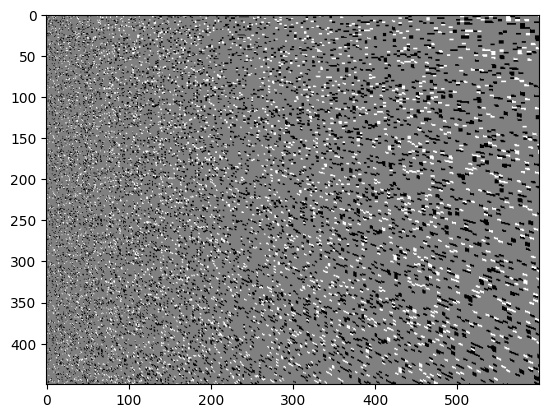

The coeficients are:
[ 2.34337611e-05 -2.47397512e-03  1.00000000e+00]


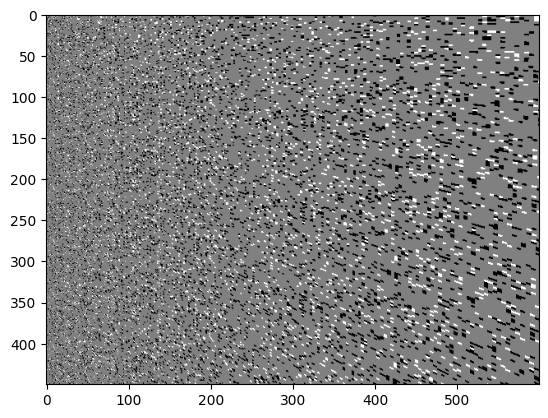

The coeficients are:
[ 4.74805521e-05 -2.49209069e-03  1.00000000e+00]


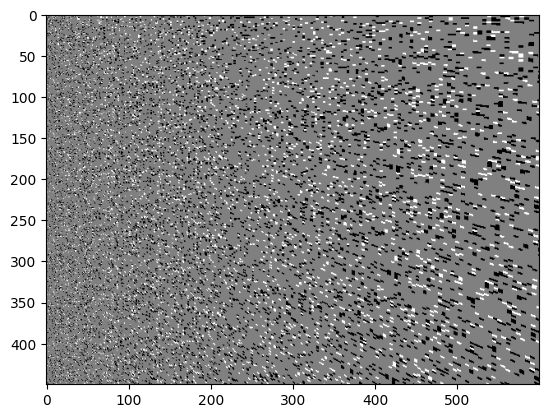

The coeficients are:
[ 1.94939348e-05 -2.47100707e-03  1.00000000e+00]


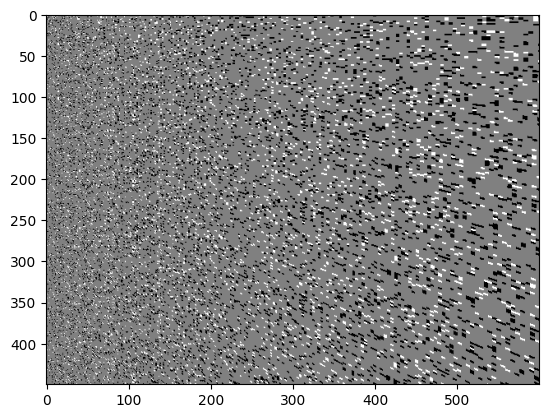

The coeficients are:
[-1.41974803e-03  6.22335684e-04  1.00000000e+00]


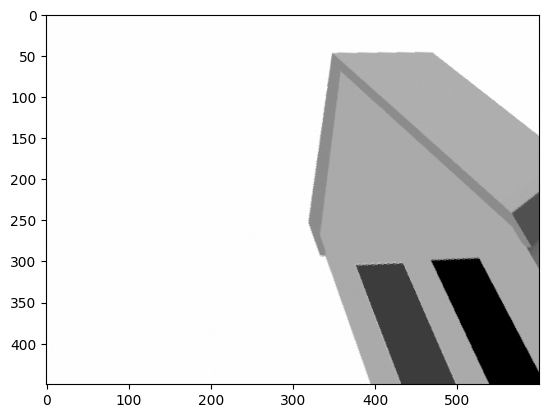

The coeficients are:
[-2.53524796e-04  6.77621712e-04  1.00000000e+00]


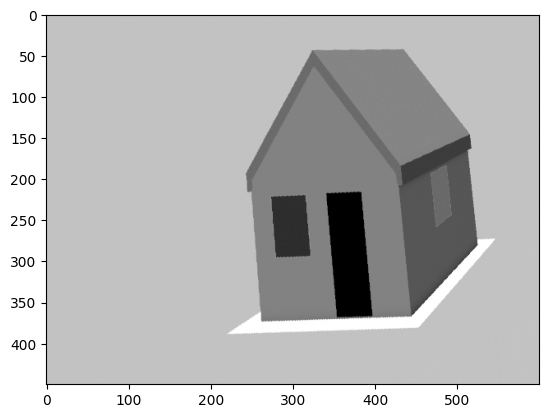

The coeficients are:
[3.57337393e-04 7.06580271e-04 1.00000000e+00]


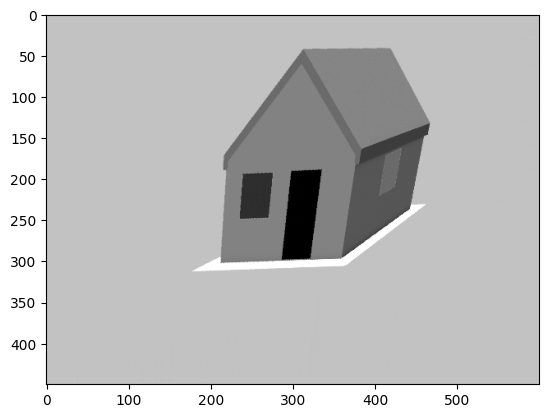

The coeficients are:
[-1.35287217e-04  6.83226888e-04  1.00000000e+00]


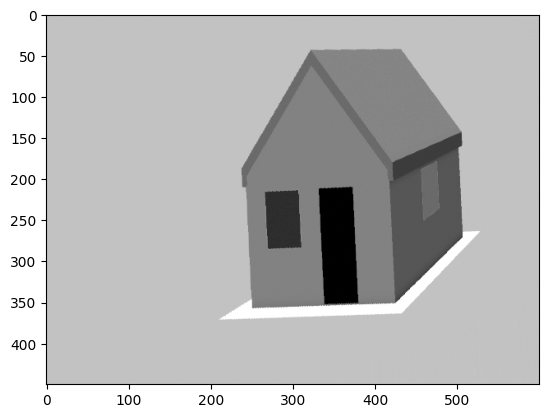

The coeficients are:
[-1.48423529e-03  7.70158138e-04  1.00000000e+00]


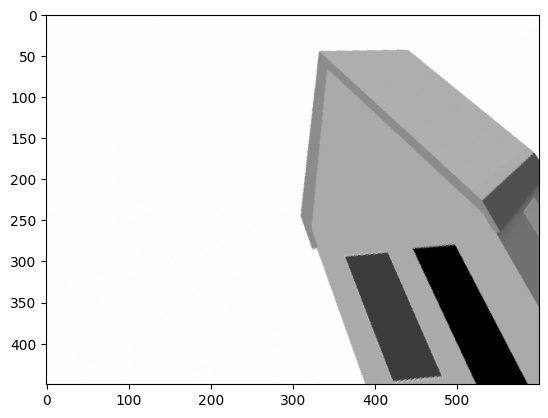

The coeficients are:
[-2.73959019e-04  9.10149029e-04  1.00000000e+00]


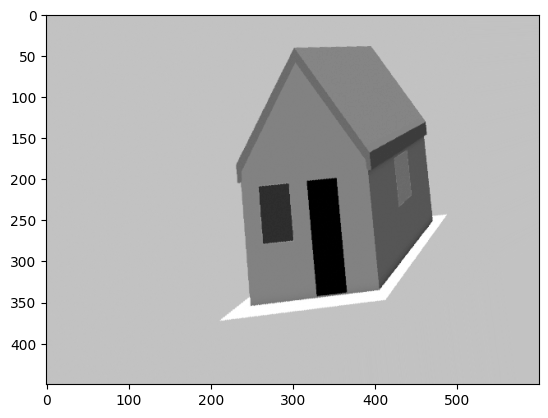

The coeficients are:
[3.84434411e-04 9.86304437e-04 1.00000000e+00]


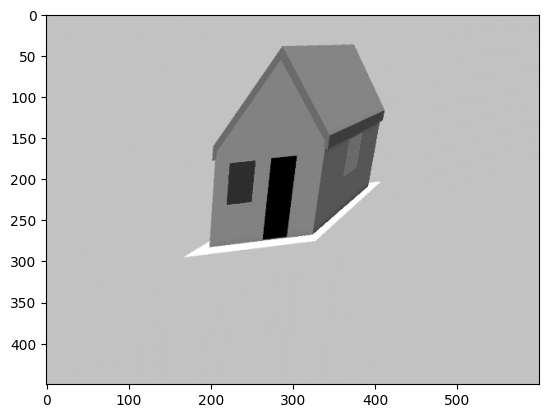

The coeficients are:
[-1.47142302e-04  9.24817734e-04  1.00000000e+00]


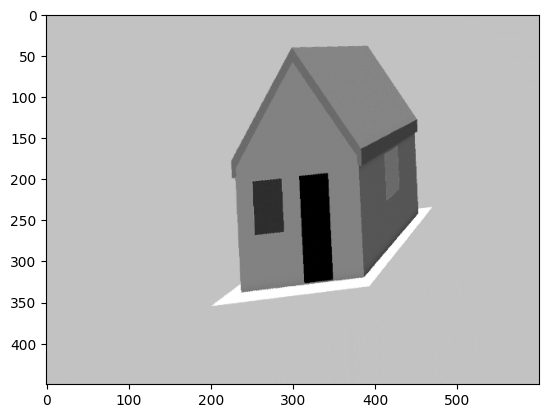

The coeficients are:
[-1.38540274e-03  5.43606881e-04  1.00000000e+00]


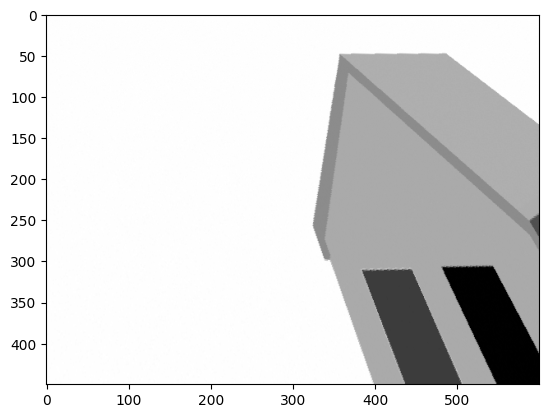

The coeficients are:
[-2.41006017e-04  5.35166660e-04  1.00000000e+00]


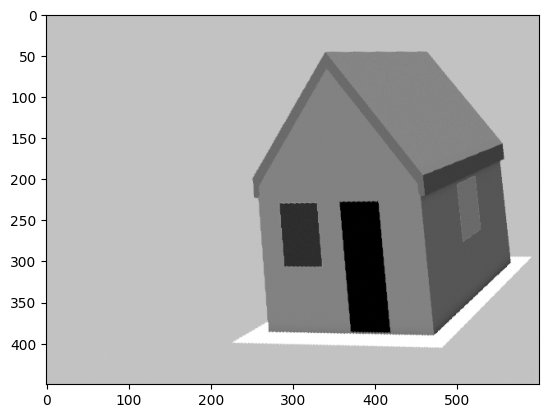

The coeficients are:
[3.40317148e-04 5.30879252e-04 1.00000000e+00]


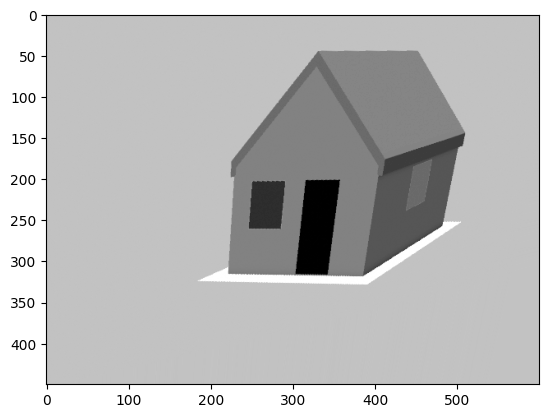

The coeficients are:
[-1.27980861e-04  5.34333071e-04  1.00000000e+00]


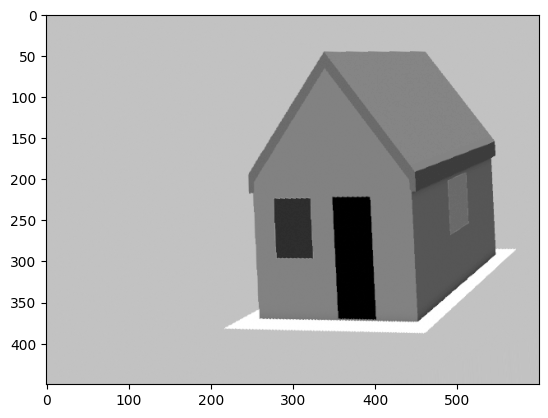

In [ ]:
import os


# Create a folder to store the transformed images
output_folder = "transformed_images"
os.makedirs(output_folder, exist_ok=True)


height, width = shtepi.shape
for s, coefficients in enumerate(coefficients_list):
    transformation_matrix = [[1, 0, 0], [0, 1, 0], coefficients]
    print("The coeficients are:")
    H_inv = np.linalg.inv(transformation_matrix)
    result = np.dot(H_inv.T, coefficients)
    print(coefficients)

    img_transformed = np.zeros((1*450, 1*600), dtype=int)
    for i, row in enumerate(img_transformed): # inverse mapping
        for j, col in enumerate(row):
            input_coords = np.array([i, j, 1])
            i_out, j_out, a =  H_inv @ input_coords
            i_out = np.round(i_out/a).astype(int).clip(0, (540)-1) # we are taking from the original img.
            j_out = np.round(j_out/a).astype(int).clip(0, (960)-1)
            img_transformed[i,j] = shtepi[i_out, j_out]
    filename = os.path.join(output_folder, f"{s}.png")
    cv2.imwrite(filename, img_transformed)
    plt.imshow(img_transformed, cmap='gray')
    plt.show()



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(540, 960)
The coeficients are:
[-0.000135287217, 0.000683226888, 1.0]


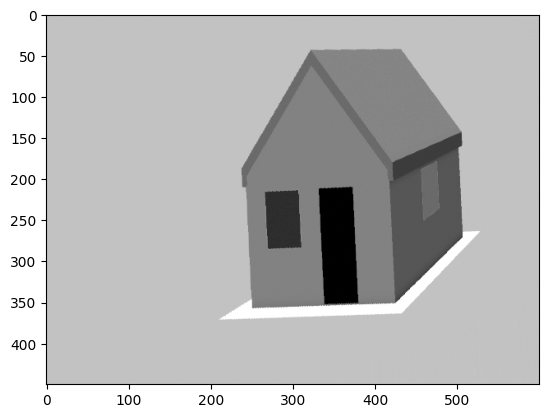

In [ ]:
# The coeficients are:
coefficients = [-1.35287217e-04,  6.83226888e-04,  1.00000000e+00]

import os

drive.mount("/content/drive/")
imgpath = '/content/drive/MyDrive/house1.png'
shtepi = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
print(np.shape(shtepi))

# Create a folder to store the transformed images
output_folder = "transformed_images"
os.makedirs(output_folder, exist_ok=True)


height, width = shtepi.shape

transformation_matrix = [[1, 0, 0], [0, 1, 0], coefficients]
print("The coeficients are:")
H_inv = np.linalg.inv(transformation_matrix)
result = np.dot(H_inv.T, coefficients)
print(coefficients)

img_transformed = np.zeros((1*450, 1*600), dtype=int)
for i, row in enumerate(img_transformed): # inverse mapping
    for j, col in enumerate(row):
        input_coords = np.array([i, j, 1])
        i_out, j_out, a =  H_inv @ input_coords
        i_out = np.round(i_out/a).astype(int).clip(0, (540)-1) # we are taking from the original img.
        j_out = np.round(j_out/a).astype(int).clip(0, (960)-1)
        img_transformed[i,j] = shtepi[i_out, j_out]
filename = os.path.join(output_folder, f"{s}.png")
cv2.imwrite(filename, img_transformed)
plt.imshow(img_transformed, cmap='gray')
plt.show()


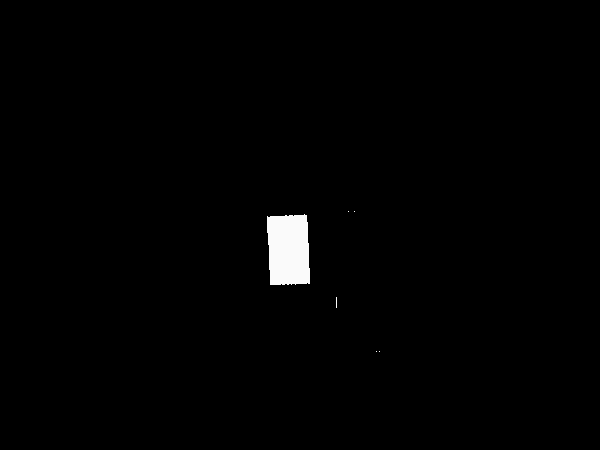

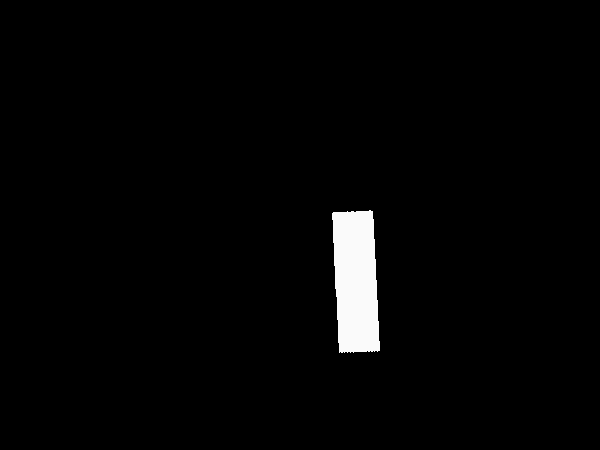

In [ ]:
#@title Separation based by histogram.
window_door2 = img_transformed.copy()
window_door2 = image_segmentation_hist_based(window_door2, hist_val_min=60,hist_val_max=70 )

cv2_imshow(window_door2)

window_door3 = img_transformed.copy()
window_door3 = image_segmentation_hist_based(window_door3, hist_val_min=0,hist_val_max=60 )

cv2_imshow(window_door3)


In [ ]:
M = window_door2.shape[0]
N = window_door2.shape[1]
count_w = 0
# Iterate over every pixel in the image
for i in range(0,M):
  for j in range(0,N):
    if window_door2[i][j] != 0:
      count_w += 1
print(count_w)


2785


In [ ]:
M = window_door3.shape[0]
N = window_door3.shape[1]
count_d = 0
# Iterate over every pixel in the image
for i in range(0,M):
  for j in range(0,N):
    if window_door3[i][j] != 0:
      count_d += 1
print(count_d)


5781


In [ ]:
print(count_d/count_w)

2.0757630161579894
